In [178]:
%matplotlib inline
from collections import OrderedDict
from operator import itemgetter
from enum import Enum

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial import distance
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

def normal(size, mean=0, sd=1):
    return np.random.normal(mean, sd, size).tolist()

class Opportunity(Enum):
    """
    The enumeration of possible records classes.
    """
    IDEAL = -1
    EXTREMELY_LIKELY = 0
    LIKELY = 1
    SWING = 2
    UNLIKELY = 3
    EXTREMELY_UNLIKELY = 4

    @classmethod
    def to_verbose(cls, op):
        return op.name.lower().replace("_", " ").title()

In [2]:
# data generation
size = 100
data = pd.DataFrame({
    "num1": normal(size),
    "num2": normal(size, mean=3),
    "num3": normal(size, mean=5)
})

In [3]:
# data preprocessing
scaler = StandardScaler()
columns = data.columns.tolist()
X = pd.DataFrame(scaler.fit_transform(data), columns=columns)
ideal_centroid = X.mean()
X = X.append(ideal_centroid, ignore_index=True)

In [4]:
# fit model
model = KMeans(n_clusters=5, init='k-means++')
labels = model.fit_predict(X)
centers = model.cluster_centers_
distances = {i: distance.euclidean(ideal_centroid, c)
             for i, c in enumerate(centers)}

opportunities = [Opportunity(i) for i, _ in enumerate(centers)]
label_to_opportunity = dict(zip(
    [i for i, _ in sorted(distances.items(), key=itemgetter(1))],
    opportunities
))

In [5]:
# calculate distances to local and ideal 
rows = [row.tolist() for _, row in X.iterrows()]
cluster_distances = [distance.euclidean(centers[l], r) for l, r in zip(labels, rows)]
ideal_distances = [distance.euclidean(ideal_centroid, r) for r in rows]
min_max_scaler = MinMaxScaler()

df = X.copy()
df["x"] = min_max_scaler.fit_transform(cluster_distances).tolist()
df["y"] = min_max_scaler.fit_transform(ideal_distances).tolist()
df["labels"] = labels
df["opportunity"] = [Opportunity.to_verbose(label_to_opportunity[l]) for l in labels]

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


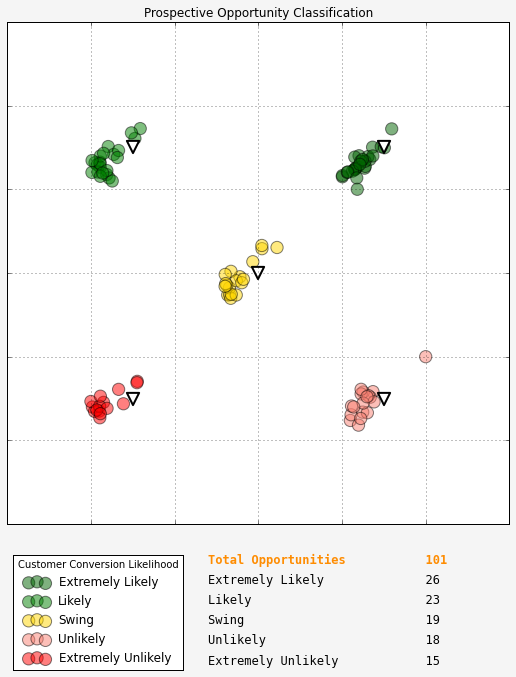

In [197]:
# plotting
def reorder_legend(ax, legend_order):
    sort = list(sorted(
        [(l, lbl) for l, lbl in zip(*ax.get_legend_handles_labels())],
        key=lambda pair: legend_order[pair[1]]))
    return zip(*sort)


figure = plt.figure(figsize=(9, 10), facecolor='whitesmoke')
figure.canvas.draw()
ax = figure.add_subplot(111)
ax.set_aspect('equal', adjustable='box')

cluster_parameters = OrderedDict()
cluster_parameters["Extremely Likely"] = {"x_offset": 4, "y_offset": 4, "color": "darkgreen"}
cluster_parameters["Likely"] = {"x_offset": 1, "y_offset": 4, "color": "green"}
cluster_parameters["Swing"] = {"x_offset": 2.5, "y_offset": 2.5, "color": "gold"}
cluster_parameters["Unlikely"] = {"x_offset": 4, "y_offset": 1, "color": "salmon"}
cluster_parameters["Extremely Unlikely"] = {"x_offset": 1, "y_offset": 1, "color": "red"}

stats = [("Total Opportunities", len(df), "darkorange", "heavy")]

for op, params in cluster_parameters.items():
    subset = df[df.opportunity == op].copy()
    stats.append((op, len(subset), "black", "normal"))
    dx = params["x_offset"]
    dy = params["y_offset"]
    subset.x += dx
    subset.y += dy
    colors = [params["color"]] * len(subset)
    subset.plot.scatter(x="x", y="y", c=colors, ax=ax, s=150, alpha=0.5, label=op)
    
    cx = params["x_offset"] + 0.5
    cy = params["y_offset"] + 0.5
    ax.scatter(cx, cy,
               s=150,
               marker="v",
               lw=2,
               edgecolor="black",
               facecolor="white")
    
ax.grid("on")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.set_xlim(0, 6)
ax.set_ylim(0, 6)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Prospective Opportunity Classification")

legend_order = dict([(v, k) for k, v in enumerate(cluster_parameters.keys())])
lines, labels = reorder_legend(ax, legend_order)
ax.legend(lines, labels,
          title="Customer Conversion Likelihood",
          loc="upper left", bbox_to_anchor=(0.0, -0.05))

y, step = -0.085, -0.04
for stat_name, count, color, weight in stats:        
    text = stat_name.ljust(30) + str(count)
    ax.text(x=0.4, y=y, s=text,
            color=color,
            fontweight=weight,
            fontsize=12,
            family='monospace',            
            horizontalalignment='left',
            verticalalignment='bottom',
            transform=ax.transAxes)
    y += step
    
figure.savefig("/Users/ck/Desktop/demo.png", format='png', bbox_inches='tight')

In [ ]:
from functools import singledispatch